In [1]:
# Import statements
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import pandas as pd
from statsmodels.tsa.stattools import acf
from scipy.interpolate import interp1d

$R_0 = \dfrac{\beta\delta}{(\delta+\mu)(\gamma+\mu)}\Rightarrow \beta = \dfrac{R_0(\delta+\mu)(\gamma+\mu)}{\delta}$

In [2]:
# Constant Parameters
N = 1e5  # Total population
delta = 1/5 # Symptom onset rate (1/delta is the infectious)
gamma = 1/10  # Recovery rate (1/gamma is the infectious period)
R_0 = 4 # Basic reproduction number estimated for alpha variant
mu = 0.00003424657  # Birth and death rate
initial_infected = 10
initial_exposed = 0
max_time = 200
beta0 = R_0 * (delta+mu)*(gamma+mu)/delta
num_res = 100
print(beta0)

beta_trans = 1 * (delta+mu)*(gamma+mu)/delta
print(beta_trans)

0.40020550287655116
0.10005137571913779


## Constant sim: $\beta(t)=\beta_0$
## Increasing sim: $\beta(t)=\beta_0+p*(t-\tau)$
## Decreasing sim: $\beta(t)=\beta_0-p$
## Step sim: $\beta(t)=\beta_0(1-H(t-\tau))+\beta_1(H(t-\tau))$

In [3]:
def test_int(X, t, betat, gamma, delta, mu):
    '''
    ODE's for Model 2: SIS with increasing vaccination rate model (elimination by vaccination)
    returns: prevalence mean-field equations (dI/dt), variance of fluctuations (Ivar, d\zeta/dt) and kurtosis of fluctuations (Ikurt)
    RUN: defines if p(t) (rate of vaccine uptake) will be slowing increasing for Ext simulations or fixed for null simulations 
    '''
    S = -betat(t)*X[0]*X[2]-mu*X[0]+mu
    E = betat(t)*X[0]*X[2]-(mu+delta)*X[1]
    I = delta*X[1] - (mu+gamma)*X[2]

    A = np.matrix([[-betat(t)*X[2]-mu, 0, -betat(t)*X[0]], 
                   [betat(t)*X[2],-(delta+mu),betat(t)*X[0]],
                   [0,delta,-(gamma+mu)]])
    B = np.matrix([[betat(t)*X[0]*X[2]+mu*X[0]+mu,-betat(t)*X[0]*X[2],0],
                   [-betat(t)*X[0]*X[2],betat(t)*X[0]*X[2]+(delta+mu)*X[1],-delta*X[1]],
                   [0,-delta*X[1],delta*X[1]+(gamma+mu)*X[2]]])

    Θ = np.matrix([[X[3],X[4],X[5]],
                   [X[4],X[6],X[7]],
                   [X[5],X[7],X[8]]])

    K = A*Θ +Θ*A.transpose()+B/1e5
    return [S, E, I, K[0,0], K[0,1], K[0,2], K[1,1], K[1,2], K[2,2]]

In [4]:
betat = lambda x: 0.4002
p = (0.4002-0.05)/100
tau = 30
def beta_increasing_t(t):
    betat = 0.05+p*(t-tau) if t > tau else 0.05
    if betat >= 0.4002:
        return 0.4002
    else:
        return betat

def beta_decreasing_t(t):
    betat = 0.4002-p*(t-tau) if t > tau else 0.4002
    if betat <= 0.05:
        return 0.05
    else:
        return betat

def beta_step_t(t):
    return 0.4002 if t<tau else 0.05

from scipy.integrate import odeint
ts = np.arange(0,200.1,0.1)
cst_theory = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(betat,1/10,1/5,0.00003424657))
cst_inc = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_increasing_t,1/10,1/5,0.00003424657))
cst_dec = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_decreasing_t,1/10,1/5,0.00003424657))
cst_step = odeint(test_int,[(1e5-10)/1e5,0,10/1e5,0,0,0,0,0,0],ts,args=(beta_step_t,1/10,1/5,0.00003424657))

In [11]:
theta_theory = np.array([np.matrix([[cst_theory[i,3],cst_theory[i,4],cst_theory[i,5]],
                [cst_theory[i,4],cst_theory[i,6],cst_theory[i,7]],
                [cst_theory[i,5],cst_theory[i,7],cst_theory[i,8]]]) for i in range(len(cst_theory))])
theta_inc = np.array([np.matrix([[cst_inc[i,3],cst_inc[i,4],cst_inc[i,5]],
                [cst_inc[i,4],cst_inc[i,6],cst_inc[i,7]],
                [cst_inc[i,5],cst_inc[i,7],cst_inc[i,8]]]) for i in range(len(cst_inc))])
theta_dec = np.array([np.matrix([[cst_dec[i,3],cst_dec[i,4],cst_dec[i,5]],
                [cst_dec[i,4],cst_dec[i,6],cst_dec[i,7]],
                [cst_dec[i,5],cst_dec[i,7],cst_dec[i,8]]]) for i in range(len(cst_dec))])
theta_step = np.array([np.matrix([[cst_step[i,3],cst_step[i,4],cst_step[i,5]],
                [cst_step[i,4],cst_step[i,6],cst_step[i,7]],
                [cst_step[i,5],cst_step[i,7],cst_step[i,8]]]) for i in range(len(cst_step))])

In [36]:
jac_theory = np.array([np.matrix([[-betat(ts[i])*cst_theory[i,2]-mu, 0, -betat(ts[i])*cst_theory[i,0]],[betat(ts[i])*cst_theory[i,2],-(delta+mu),betat(ts[i])*cst_theory[i,0]],[0,delta,-(gamma+mu)]]) for i in range(len(theta_theory))])
jac_inc = np.array([np.matrix([[-beta_increasing_t(ts[i])*cst_inc[i,2]-mu, 0, -beta_increasing_t(ts[i])*cst_inc[i,0]],[beta_increasing_t(ts[i])*cst_inc[i,2],-(delta+mu),beta_increasing_t(ts[i])*cst_inc[i,0]],[0,delta,-(gamma+mu)]]) for i in range(len(theta_inc))])
jac_dec = np.array([np.matrix([[-beta_decreasing_t(ts[i])*cst_dec[i,2]-mu, 0, -beta_decreasing_t(ts[i])*cst_dec[i,0]],[beta_decreasing_t(ts[i])*cst_dec[i,2],-(delta+mu),beta_decreasing_t(ts[i])*cst_dec[i,0]],[0,delta,-(gamma+mu)]]) for i in range(len(theta_dec))])
jac_step = np.array([np.matrix([[-beta_step_t(ts[i])*cst_step[i,2]-mu, 0, -beta_step_t(ts[i])*cst_step[i,0]],[beta_step_t(ts[i])*cst_step[i,2],-(delta+mu),beta_step_t(ts[i])*cst_step[i,0]],[0,delta,-(gamma+mu)]]) for i in range(len(theta_step))])

In [38]:
theory_jac = [np.linalg.eigvals(jac_theory[i])[0] for i in range(len(jac_theory))]
theory_jac_test = [np.linalg.eigvals(jac_theory[i])[0]/np.linalg.norm(np.linalg.eigvals(jac_theory[i])) for i in range(len(jac_theory))]
inc_jac = [np.linalg.eigvals(jac_inc[i])[0] for i in range(len(jac_inc))]
inc_jac_test = [np.linalg.eigvals(jac_inc[i])[0]/np.linalg.norm(np.linalg.eigvals(jac_inc[i])) for i in range(len(jac_inc))]
dec_jac = [np.linalg.eigvals(jac_dec[i])[0] for i in range(len(jac_dec))]
dec_jac_test = [np.linalg.eigvals(jac_dec[i])[0]/np.linalg.norm(np.linalg.eigvals(jac_dec[i])) for i in range(len(jac_dec))]
step_jac = [np.linalg.eigvals(jac_step[i])[0] for i in range(len(jac_step))]
step_jac_test = [np.linalg.eigvals(jac_step[i])[0]/np.linalg.norm(np.linalg.eigvals(jac_step[i])) for i in range(len(jac_step))]

In [24]:
theory_eig = [np.linalg.eigvals(theta_theory[i])[0] for i in range(len(theta_theory))]
theory_eig_test = [np.linalg.eigvals(theta_theory[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_theory[i])) for i in range(len(theta_theory))]
inc_eig = [np.linalg.eigvals(theta_inc[i])[0] for i in range(len(theta_inc))]
inc_eig_test = [np.linalg.eigvals(theta_inc[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_inc[i])) for i in range(len(theta_inc))]
dec_eig = [np.linalg.eigvals(theta_dec[i])[0] for i in range(len(theta_dec))]
dec_eig_test = [np.linalg.eigvals(theta_dec[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_dec[i])) for i in range(len(theta_dec))]
step_eig = [np.linalg.eigvals(theta_step[i])[0] for i in range(len(theta_step))]
step_eig_test = [np.linalg.eigvals(theta_step[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_step[i])) for i in range(len(theta_step))]

/tmp/ipykernel_9078/181246813.py:2: RuntimeWarning: invalid value encountered in scalar divide
  theory_eig_test = [np.linalg.eigvals(theta_theory[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_theory[i])) for i in range(len(theta_theory))]
/tmp/ipykernel_9078/181246813.py:4: RuntimeWarning: invalid value encountered in scalar divide
  inc_eig_test = [np.linalg.eigvals(theta_inc[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_inc[i])) for i in range(len(theta_inc))]
/tmp/ipykernel_9078/181246813.py:6: RuntimeWarning: invalid value encountered in scalar divide
  dec_eig_test = [np.linalg.eigvals(theta_dec[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_dec[i])) for i in range(len(theta_dec))]
/tmp/ipykernel_9078/181246813.py:8: RuntimeWarning: invalid value encountered in scalar divide
  step_eig_test = [np.linalg.eigvals(theta_step[i])[0]/np.linalg.norm(np.linalg.eigvals(theta_step[i])) for i in range(len(theta_step))]


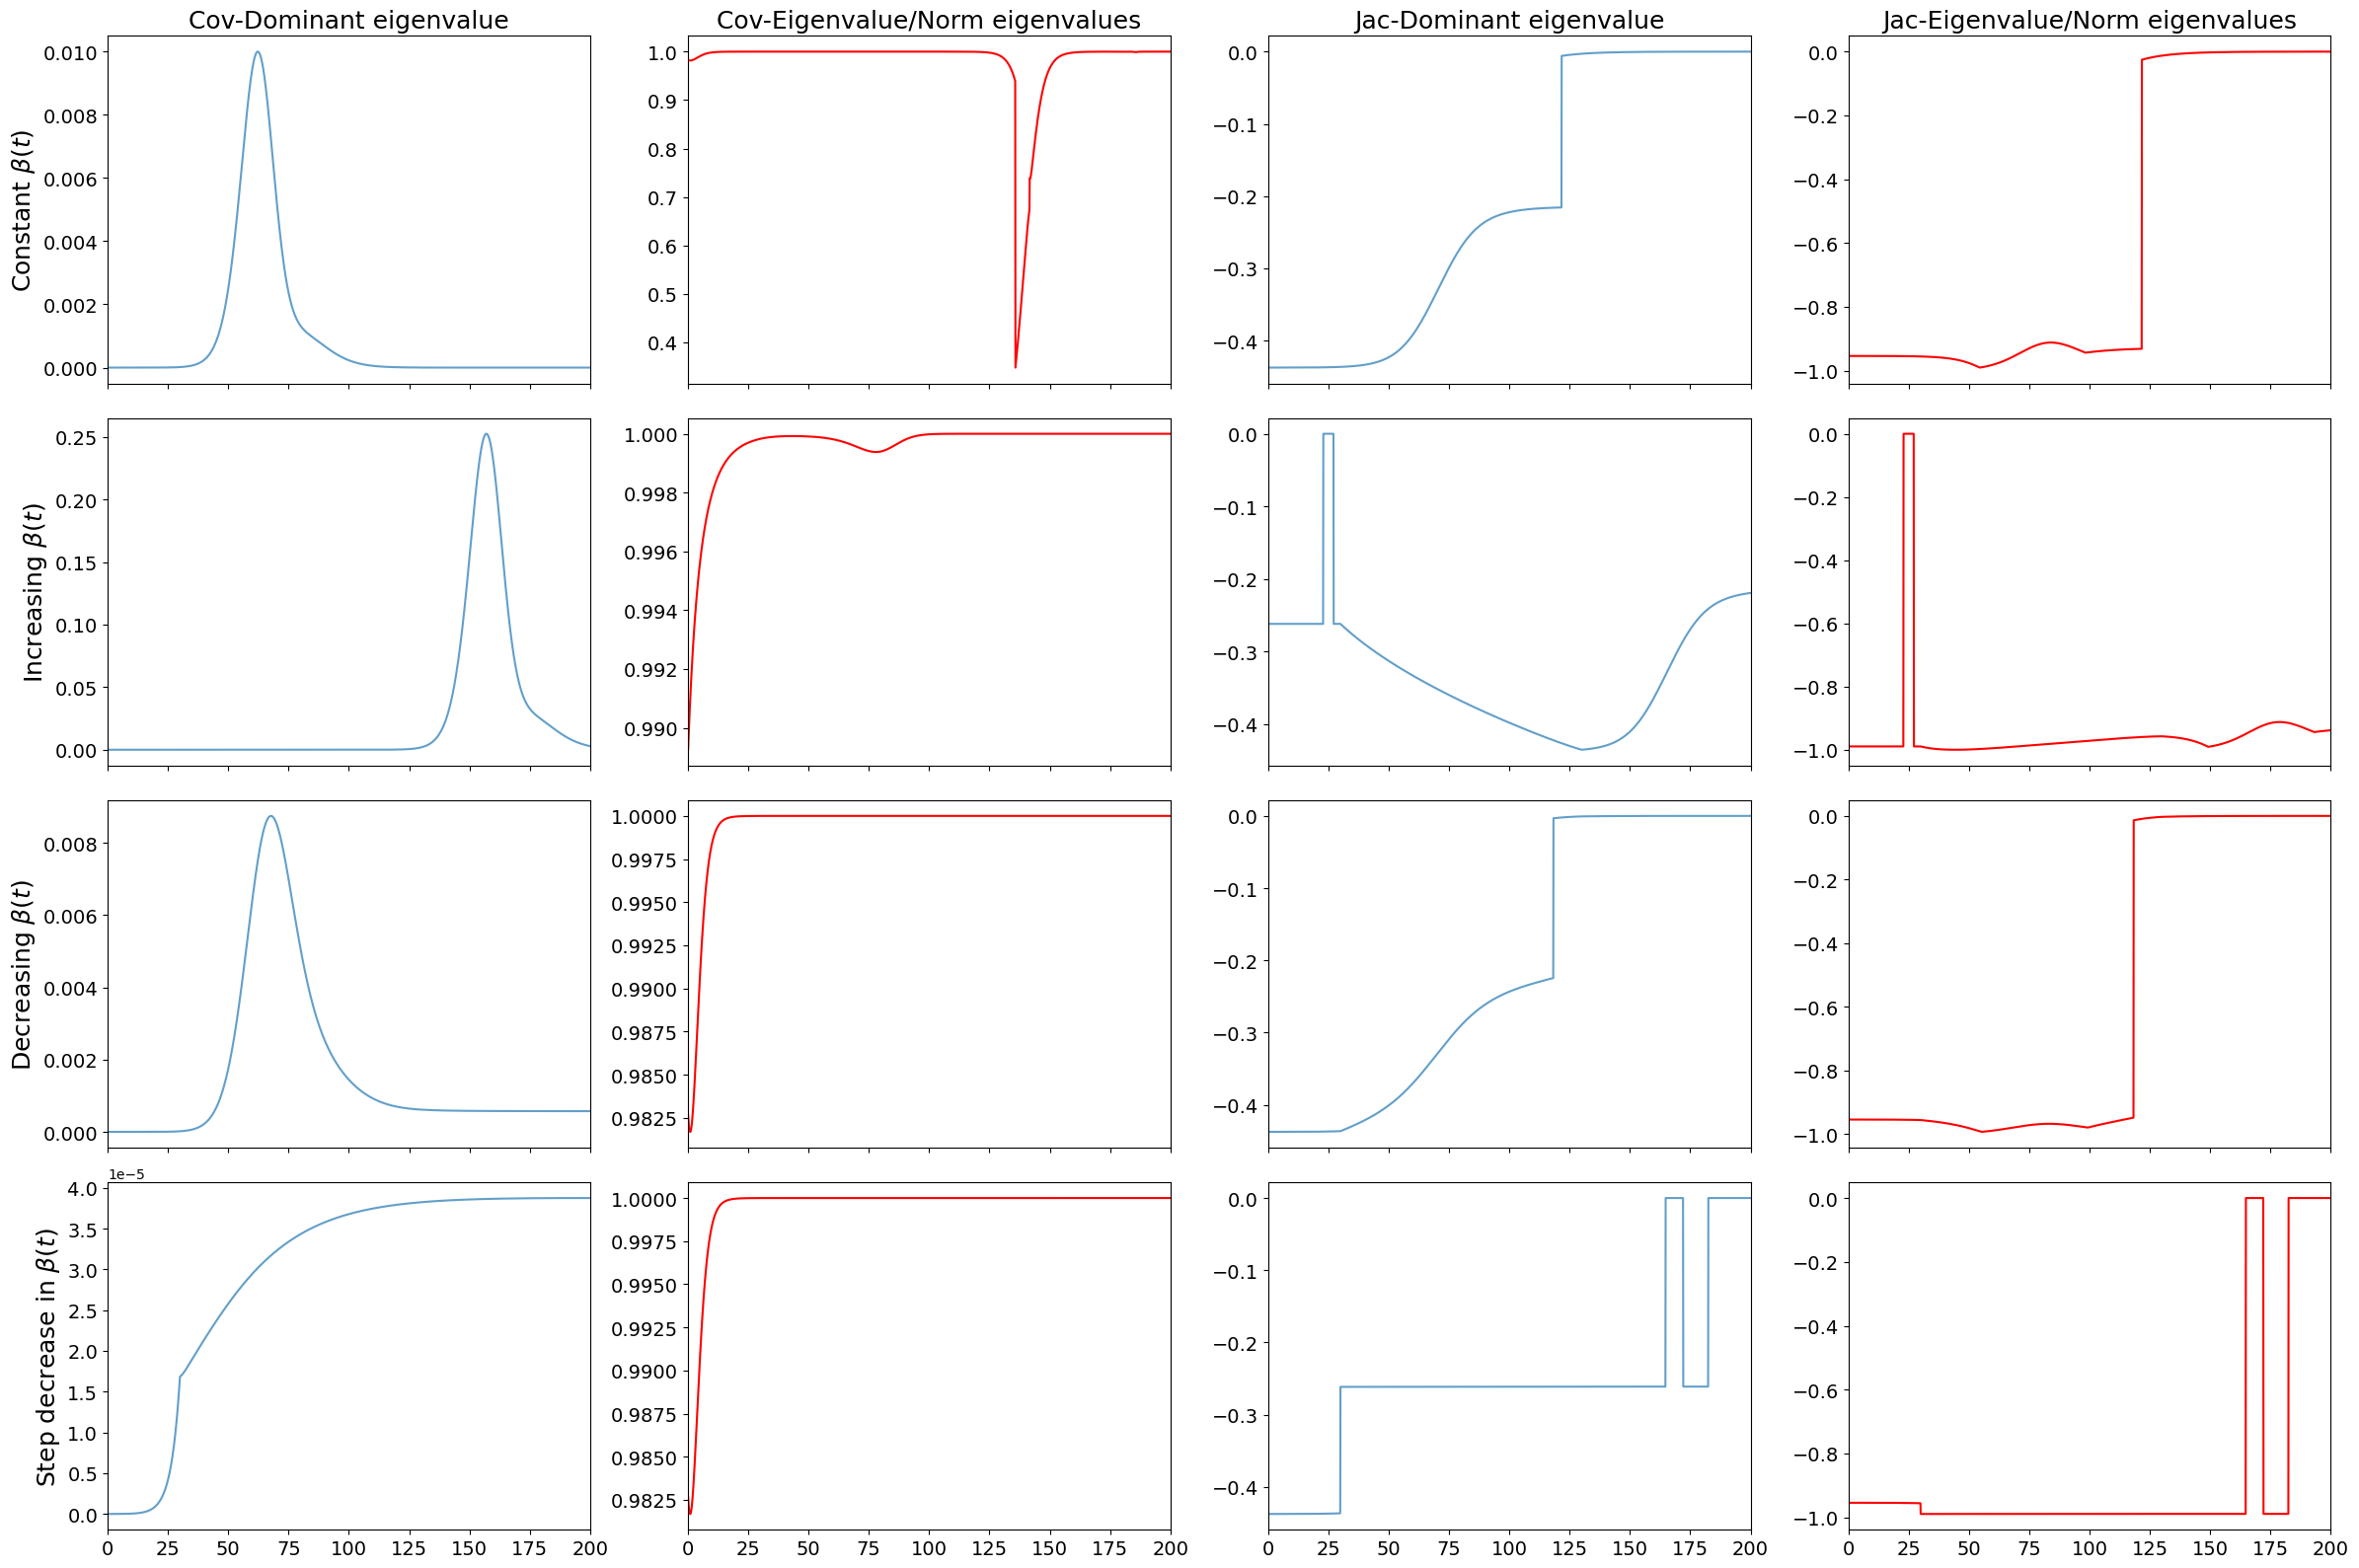

In [44]:
ts = np.arange(0,200.1,0.1)
fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(24,16),sharex=True)
axs[0,0].plot(ts,theory_eig,color='#629FCA')
axs[0,1].plot(ts,theory_eig_test,color='red')
axs[1,0].plot(ts,inc_eig,color='#629FCA')
axs[1,1].plot(ts,inc_eig_test,color='red')
axs[2,0].plot(ts,dec_eig,color='#629FCA')
axs[2,1].plot(ts,dec_eig_test,color='red')
axs[3,0].plot(ts,step_eig,color='#629FCA')
axs[3,1].plot(ts,step_eig_test,color='red')

axs[0,2].plot(ts,theory_jac,color='#629FCA')
axs[0,3].plot(ts,theory_jac_test,color='red')
axs[1,2].plot(ts,inc_jac,color='#629FCA')
axs[1,3].plot(ts,inc_jac_test,color='red')
axs[2,2].plot(ts,dec_jac,color='#629FCA')
axs[2,3].plot(ts,dec_jac_test,color='red')
axs[3,2].plot(ts,step_jac,color='#629FCA')
axs[3,3].plot(ts,step_jac_test,color='red')

# axs[0,0].vlines(constant_crit,ymin=axs[0,0].get_yticks()[0],ymax=up_lims_p[0],color='k',linestyle='--')
# axs[0,1].vlines(constant_crit,ymin=axs[0,1].get_yticks()[0],ymax=axs[0,1].get_yticks()[-1],color='k',linestyle='--')

# axs[1,0].vlines(inc_crit_up,ymin=axs[1,0].get_yticks()[0],ymax=up_lims_p[1],color='k',linestyle='--')
# axs[1,1].vlines(inc_crit_up,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')
# axs[1,0].vlines(inc_crit_down,ymin=axs[1,0].get_yticks()[0],ymax=up_lims_p[1],color='k',linestyle='--')
# axs[1,1].vlines(inc_crit_down,ymin=axs[1,1].get_yticks()[0],ymax=axs[1,1].get_yticks()[-1],color='k',linestyle='--')

# axs[2,0].vlines(dec_crit,ymin=axs[2,0].get_yticks()[0],ymax=up_lims_p[2],color='k',linestyle='--')
# axs[2,1].vlines(dec_crit,ymin=axs[2,1].get_yticks()[0],ymax=axs[2,1].get_yticks()[-1],color='k',linestyle='--')

# axs[3,0].vlines(step_crit,ymin=axs[3,0].get_yticks()[0],ymax=up_lims_p[3],color='k',linestyle='--')
# axs[3,1].vlines(step_crit,ymin=axs[3,1].get_yticks()[0],ymax=axs[3,1].get_yticks()[-1],color='k',linestyle='--')

axs[0,0].set_title('Cov-Dominant eigenvalue',fontsize=18)
axs[0,1].set_title('Cov-Eigenvalue/Norm eigenvalues',fontsize=18)
axs[0,2].set_title('Jac-Dominant eigenvalue',fontsize=18)
axs[0,3].set_title('Jac-Eigenvalue/Norm eigenvalues',fontsize=18)

labels= [r'Constant $\beta(t)$',r'Increasing $\beta(t)$', r'Decreasing $\beta(t)$', r'Step decrease in $\beta(t)$']
for i in range(4):
    for j in range(4):
        axs[i,j].tick_params(axis='x', labelsize=14)
        axs[i,j].tick_params(axis='y', labelsize=14)
        axs[i,j].set_xlim((0,200))
for i in range(4):
    axs[i,0].set_ylabel(labels[i],fontsize=18)
plt.tight_layout()
plt.show()